# Multilabel classfication of classes
Since a class itself, from a medical point of view, is classfyed by a doctor through its traits, that come from primary classes and are later given a final classification as a composite class of several primary classes; trying to label a pattern from a prediction of joint multi label classifications is intuitive.



In [1]:
image_reshape_size = 96 # multiple of 32, to fit better with VGG16
# values from image_study notebook

# Imports

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sns
import multiprocessing as mp
from sklearn.preprocessing import OneHotEncoder
# example of tending the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC
auc = AUC(name='auc')
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as spc
from sklearn.metrics import roc_auc_score
from numba import cuda

Mounting the drive

In [3]:

# import library
from google.colab import drive

#mount the drive
drive.mount('/content/drive')
# go to the url and get the password for the drive

Mounted at /content/drive


# Image viewing utils


In [4]:
def cells_plot(X, image_shape, collumn_size):
  count = 0
  limit = collumn_size*(image_shape+2)
  out = np.zeros((2,limit))
  row = np.array([])
  n = 0
  # for every cell in image
  for i, x in enumerate(X):
    if count == 0:
      row = np.c_[x, np.zeros((image_shape,2))]
    else:
      row = np.c_[row, np.c_[x, np.zeros((image_shape,2))]]
    count += 1
    if count == collumn_size:
      n += collumn_size
      out = np.r_[out, np.zeros((2,limit))]
      out = np.r_[out, row]
      row = np.array([])
      count = 0
      if n>99:
        break
  n += count
  if count != 0:
    for i in range(count, collumn_size):
        row = np.c_[row, np.c_[np.zeros((image_shape,image_shape+2))]]
    out = np.r_[out, np.zeros((2,limit))]
    out = np.r_[out, row]
  w, h = out.shape
  output = np.zeros((w, h, 3))
  output[:,:,1] = out
  return output, n


#%% SECTION de definition et d'imports a lancer au debut
# Si vous êtes dans colab mettre colaboratory ET notebook a True
# si vous êtes en local dans un notebook mettez colbaoratory a False
#      et installez bokeh vous-même
# Si vous utilisez le script sur une machine local non pas dans un notebook 
# mettez les deux à False 
notebook=True
colaboratory=True
if notebook:
    from IPython.display import Audio
    if colaboratory:
        !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    from bokeh.colors import Color as bcolor
    from bokeh.colors.rgb import RGB


import numpy as np

import matplotlib.pyplot as plt
import scipy 
from scipy.signal import lfilter
import scipy.io
import platform
import time

import tempfile
import os

def RGBtoYCrCb(im,ty='8bit'): 
    assert len(im.shape)==3 and im.shape[2]==3, 'image dans un mauvais format'
    if ty=='8bit':
        delta=128 #ce delta est simplement le milieu de la plage des valeurs 
                    # possibles. 
    out=np.empty(im.shape)
    Y=0.299*im[:,:,0]+0.587*im[:,:,1]+0.114*im[:,:,2]
    Cr=(im[:,:,0]-Y)*0.713+delta
    Cb=(im[:,:,2]-Y)*0.564+delta
    return (Y,Cr,Cb)



def YCrCbtoRGB(Y,Cr,Cb,ty='8bit'):
    delta=128
    out=np.empty([*Y.shape,3],dtype=np.float32)
    out[:,:,0]=Y+1.402*(Cr-delta)
    out[:,:,1]=Y-0.34414*(Cb-128)-0.71414*(Cr-128)
    out[:,:,2]=Y+1.772*(Cb-128)
    return out
    
import skimage.transform
if notebook:
  liste_couleurs_grises=[]
  for k in range(256):
    liste_couleurs_grises.append(RGB(k,k,k))
  def affiche_pour_colab(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''): #special colab, ne pas regarder
    def normalise_image_pour_bokeh(X,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
      Y=(X.copy())
      if len(Y.shape)==2: 
        Y=np.zeros((*Y.shape,3))
        for k in range(3):
          Y[:,:,k]=X.copy()
   
      if normalise:
        Y-=Y.min()
        Y/=Y.max()
        Y*=255
      else:
        Y-=MINI
        Y/=(MAXI-MINI)
        Y*=255

      Y=Y.astype(np.uint8)
      sortie=np.empty(Y.shape[:2],dtype=np.uint32)
      view=sortie.view(dtype=np.uint8).reshape((Y.shape[:2]+(4,)))
      for k in range(3):
        view[:,:,k]=Y[:,:,k]
      view[:,:,3]=255
      return sortie
    img=normalise_image_pour_bokeh(np.flipud(im),normalise=normalise,MINI=MINI,MAXI=MAXI)# np.flipud(np.fliplr(im)))
    p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],title=titre)
    p.x_range.range_padding = p.y_range.range_padding = 0

    # must give a vector of images
    p.image_rgba(image=[img],x=0,y=0, dw=im.shape[1], dh=im.shape[0])
    showbokeh(p)

  def affiche(im,normalise=True,MINI=0.0, MAXI=255.0,titre='',printname=False):
      affiche_pour_colab(im,normalise=normalise,MINI=MINI, MAXI=MAXI,titre=titre) 
         # sous google colab beaucoup d''options disparaissent

else:
    def affiche(im,normalise=True,MINI=0.0, MAXI=255.0,titre='',printname=False):
        """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image 
        resultat
        """
        imt=np.float32(im.copy())
        if platform.system()=='Darwin': #on est sous mac
            prephrase='open -a GIMP-2.10.app ' #certainement à adapter
            endphrase=' ' 
        else: #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment 
                                   #faire. Si vous savez dites-moi.)
            prephrase='gimp '
            endphrase= ' &'
    
        if normalise:
            m=imt.min()
            imt=imt-m
            M=imt.max()
            if M>0:
                imt=imt/M

        else:
            imt=(imt-MINI)/(MAXI-MINI)
            imt[imt<0]=0
            imt[imt>1]=1
    
        if titre!='':
            titre='_'+titre+'_'
        titre=titre.replace(' ','')
        nomfichier=tempfile.mktemp('TPIMA'+titre+'.png')
        commande=prephrase +nomfichier+endphrase
        os.system(commande)
        if printname:
            print(nomfichier)


if notebook:
    def plot(*argv):
        if len(argv)==2:
            x=argv[0]
            y=argv[1]
        elif (len(argv)==1):
            x=np.arange(0,len(y))
            y=argv[0]
        else:
            raise Exception("Erreur dans les graphiques: n'arriverait \
                pas hors de google colaboratory")
    
        p=figure()
        p.line(x,y)
        showbokeh(p)
    def stem(*argv):
        if len(argv)==2:
            x=argv[0]
            y=argv[1]
        elif len(argv)==1:
            x=np.arange(0,len(y))
            y=argv[0]
        else:
            raise Exception("Erreur dans les graphiques: \
                            n'arriverait pas hors de google colaboratory")

        p = figure()#title="simple line example", x_axis_label='x',
                    #y_axis_label='y')

        # add a line renderer with legend and line thickness
        p.segment(x,0,x, y, legend_label="Temp.", line_width=2)

        showbokeh(p)
    def show():
        return
else:
    plot=plt.plot
    stem=plt.stem
    show=plt.show # force l'affichage du graphique courant

def norm(X):
    return ((abs(X)**2).sum())**0.5

# Importing images

In [5]:
def get_patterns(pattern_folder, cell_number_limit, green=False):
  print('Importing...')
  n_classes = len(glob.glob(pattern_folder + '/*'))
  y_pattern_dict = n_classes*[None]

  X = [] #dataset
  y = []
  i = 0
  dif = 0
  hist_pixel_count = [[] for i in range(n_classes)] #matrix with cell pixel count per pattern
  hist_percentage_cyto = [[] for i in range(n_classes)]#matrix with cell max dimension per pattern

  for pattern_path in sorted(glob.glob(pattern_folder + '/*')): #iterating in every pattern
    pattern_name =  pattern_path[len(pattern_folder)+1:] #Name of pattern
    y_pattern_dict[i] = pattern_name
    print(f'Importing patterns: {pattern_name} - {i}/{n_classes}')
    number_of_images = 0
    while number_of_images<cell_number_limit:
      for idx, np_cells in enumerate(sorted(glob.glob(pattern_path + '/*'))):#iterating for every numpy array
        if number_of_images>=cell_number_limit:
          break
        
        if (green == True and np_cells[-5]=='G') or (green == False and np_cells[-5]!='G'):
          a = np.load(np_cells, allow_pickle=True) #gets array from drive
          print(f'{np_cells[len(pattern_path)+1:]} - {len(a)}') 
          number_of_images += len(a)
          # One hot encoder
          auxy = np.zeros(n_classes)
          auxy[i] = 1
          for j in range(len(a)):
            y.append(auxy)
          
          #histogram construction
          for img in a:
            X.append(img[:,:,0])
            size = img.shape[0]*img.shape[1]
            hist_pixel_count[i].append(size)
            hist_percentage_cyto[i].append(100*np.count_nonzero(img[:,:,2]==0)/size)
          # augmentation for missing images
          # check for errors
          if len(X) != len(y):
            if len(X) - len(y) != dif:
              err_npy = np_cells
              dif = len(X) - len(y)
            print(f'problem: {err_npy} / {len(X)} - {len(y)}')
            return a, y, X, 0, 0, 0
    i += 1
  y = np.array(y)
  return X, y, n_classes, y_pattern_dict, hist_pixel_count, hist_percentage_cyto

def get_patterns_by_image(pattern_folder, cell_number_limit, image_path, green=True):
  print('Importing...')
  n_classes = len(glob.glob(pattern_folder + '/*'))
  y_pattern_dict = n_classes*[None]
  
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  #dataset
  image_x = []
  image_y = []
  hist_pixel_count = [[] for i in range(n_classes)] #matrix with cell pixel count per pattern
  hist_percentage_cyto = [[] for i in range(n_classes)]#matrix with cell max dimension per pattern
  i = 0
  dif = 0
  cells_paths = sorted(glob.glob(pattern_folder + '/*'))
  images = sorted(glob.glob(image_path + '/*'))
  for number_of_images, pattern_path in enumerate(cells_paths): #iterating in every pattern
    X = []
    y = []
    pattern_name =  pattern_path[len(pattern_folder)+1:] #Name of pattern
    y_pattern_dict[i] = pattern_name
    for aux in sorted(glob.glob(images[number_of_images] + '/*')):
      if aux[-3:]=='jpg':
        img = np.asarray(cv2.imread(aux))
        img[:,:,1] = clahe.apply(img[:,:,1])
        plt.figure(figsize=(20,10))
        plt.imshow(img)
        plt.title(f'Pattern {pattern_name}')
        plt.show()
        break
    for count_images,np_cells in enumerate(glob.glob(pattern_path + '/*')):#iterating for every numpy array
      if (green == True and np_cells[-5]=='G') or (green == False and np_cells[-5]!='G'):
        a = np.load(np_cells, allow_pickle=True) #gets array from drive
        print(f'{np_cells[len(pattern_path)+1:]} - {len(a)}') 
        number_of_images += len(a)
        # One hot encoder
        auxy = np.zeros(n_classes)
        auxy[i] = 1
        for j in range(len(a)):
          y.append(auxy)
        
        #histogram construction
        for img in a:
          X.append(img[:,:,0])
          size = img.shape[0]*img.shape[1]
          hist_pixel_count[i].append(size)
          hist_percentage_cyto[i].append(100*np.count_nonzero(img[:,:,2]==0)/size)
        # augmentation for missing images
        # check for errors
        if len(X) != len(y):
          if len(X) - len(y) != dif:
            err_npy = np_cells
            dif = len(X) - len(y)
          print(f'problem: {err_npy} / {len(X)} - {len(y)}')
          return a, y, X, 0, 0, 0
      
    i += 1
    image_x.append(X) 
    image_y.append(np.array(y))
  return image_x, image_y, n_classes, y_pattern_dict, hist_pixel_count, hist_percentage_cyto


In [6]:
def get_primary_classes(pattern_folder = '/content/drive/MyDrive/Images/Cells/Full_image_cells/*'):
    primary_classes = []
    pattern_dict = []
    for pattern in sorted(glob.glob(pattern_folder)):
      pattern_name =  pattern[len(pattern_folder)-1:].lower() #Name of pattern
      pattern_dict.append(pattern_name)
      for pc in pattern_name.split():
        if pc not in primary_classes:
          primary_classes.append(pc)
    
    primary_df = pd.DataFrame(index=primary_classes, columns=pattern_dict)
    for pattern in sorted(glob.glob(pattern_folder)):
      pattern_name =  pattern[len(pattern_folder)-1:].lower() #Name of pattern
      for pc in primary_classes:
        if pc in pattern_name.split():
          primary_df[pattern_name].loc[pc] = 1
        else:
          primary_df[pattern_name].loc[pc] = 0

    return primary_df, primary_classes

def category_to_multi_label(y_list, y_dict, dict_primary):
  # for all classes in y (categorical with dict)
  # make it as a multilable following primary dict 
  new_y = np.zeros((y_list.shape[0], dict_primary.shape[0]))
  for idx, y in enumerate(y_list):
    pattern = y_dict[np.argmax(y)]
    new_y[idx] = dict_primary[pattern.lower()].values.astype('float32')
  return new_y.T



# Preparing the dataset

In [7]:
def transform_square(X):
  #Images are currently cropped around the cell, this function makes all cells have a black square around them with the same
  #size with the size of their largest dimension
  Xcopy = X.copy()
  for i in range(len(X)):
    #print(i)
    if X[i].shape[0] != X[i].shape[1]:
      max_dimension = max(X[i].shape[0],X[i].shape[1])
      aux = np.zeros((max_dimension, max_dimension))
      if max_dimension == X[i].shape[0]:
        margin = int((max_dimension - X[i].shape[1])/2)
        aux[:, margin: X[i].shape[1]+margin] = X[i]
      else:
        margin = int((max_dimension - X[i].shape[0])/2)
        aux[margin: X[i].shape[0]+margin, :] = X[i]
      Xcopy[i] = aux
  return Xcopy

def standardize_classes(X, y):
  Xcopy = X.copy()
  for i in range(len(y[0])): #iterating between 14 classes
    arr = np.where(y[:, i]==1)[0]
    max_dimension = 0
    for cell in X[arr]: #find the largest dimension in a given class
      max_dimension = max(cell.shape[0], max_dimension)
    for j in arr:
      aux = np.zeros((max_dimension, max_dimension))
      margin = int((max_dimension - X[j].shape[0])/2)
      aux[margin: margin + X[j].shape[0], margin: margin + X[j].shape[0]] = X[j]
      Xcopy[j] = aux
  return Xcopy

def resize_square(X, cnn_input_size, upscaling=False, full_size=True):
  # The resizing implemented is:
    # For smaller cells: no upscaling, just placing a smaller cell in a bigger black square if upscaling is false
      #If upscaling is true, then it upscales
    # for bigger cells: downscaling
  if full_size:
    Xcopy = np.zeros((len(X), cnn_input_size, cnn_input_size))
    for i in range(len(X)):
      aux = cv2.resize(X[i], dsize=(cnn_input_size, cnn_input_size), interpolation=cv2.INTER_CUBIC)
      Xcopy[i] = np.asarray(aux, 'float32')
    return Xcopy
  if upscaling==True:
    X = standardize_classes(X, y)
  Xcopy = np.zeros((len(X), cnn_input_size, cnn_input_size))
  for i in range(len(X)):
    if X[i].shape[0] < cnn_input_size and upscaling==False:
      aux = np.zeros((cnn_input_size, cnn_input_size))
      margin = int((cnn_input_size - X[i].shape[0])/2)
      aux[margin: margin + X[i].shape[0], margin: margin + X[i].shape[0]] = X[i]
    elif X[i].shape[0] >= cnn_input_size or upscaling==True:
      aux = cv2.resize(X[i], dsize=(cnn_input_size, cnn_input_size), interpolation=cv2.INTER_CUBIC)
    Xcopy[i] = np.asarray(aux, 'float16')
  return Xcopy

def grayscale_2_3channel(X):
  #copies grayscale into other channels for VGG
  return np.repeat(np.expand_dims(X, 3), 3, axis=3)
  
def filter_db(X, y, pixel_count, percentage):
  # returns X and y inside parameters of
  # pixel_count and percentage of empty space
  Xl = []
  yl = []
  for i in range(len(X)):
    iclass = np.argmax(y[i])
    size = X[i].shape[0]*X[i].shape[1]
    percent = (100*np.count_nonzero(X[i]==0))/size
    if size < pixel_count[iclass][0] and size > pixel_count[iclass][1]:
      if percent < percentage[iclass][0] and percent > percentage[iclass][1]:
        Xl.append(X[i])
        yl.append(y[i])
  return Xl,np.asarray(yl)

def data_augmentation(X, y):
  # data augmentation using fliping and rotation
  x_out = np.copy(X)
  y_out = np.copy(y)
  flips = np.asarray([np.flipud(img) for img in X])
  x_out = np.concatenate((x_out, flips))
  y_out = np.concatenate((y_out, y))
  flips = np.asarray([np.fliplr(img) for img in X])
  x_out = np.concatenate((x_out, flips))
  y_out = np.concatenate((y_out, y))
  flips = np.asarray([np.flip(img, (0, 1)) for img in X])
  x_out = np.concatenate((x_out, flips))
  y_out = np.concatenate((y_out, y))
  return x_out, y_out


def data_preparation (X, y, split_test, hist_pixel_count, hist_percentage, image_reshape_size, y_pattern_dict):
  
  print("Filtering")
  pixel_parameters = get_parameters(hist_pixel_count, len(y_pattern_dict), y_pattern_dict)
  percentage_parameters = get_parameters(hist_percentage, len(y_pattern_dict), y_pattern_dict, True)
  X_filtered, y_filtered = filter_db(X, y, pixel_parameters, percentage_parameters)
  if split_test:
    print(f'the total number of images is: {len(y)}')
    print(f'the number of images with these restrictions is: {len(y_filtered)}')
  print('Normalizing images')
  imgs_normalized = normalize(X_filtered)
  print("Making cells square")
  square = transform_square(imgs_normalized)
  print("Resizing to the correct size for classification")
  res_square = resize_square(square, image_reshape_size)
  #print(np.max(res_square))
  cells = grayscale_2_3channel(res_square)
  print("Train test splitting")
  if split_test:
    Xtrain, Xtest, ytrain, ytest = train_test_split(cells, y_filtered, test_size=0.25, random_state=42)
    print('Data augmentation')
    Xtrain, ytrain = data_augmentation(Xtrain, ytrain)
    return Xtrain, ytrain, Xtest, ytest
  return cells, y_filtered

def normalize(X):
    for idx, img in enumerate(X):
        ar = np.array(img).astype(np.float32)
        mn = np.min(ar)
        mx = np.max(ar)
        X[idx] = (ar - mn) * (1.0 / (mx - mn))
    return X


def get_parameters(hist, n_classes, y_pattern_dict, percent=False):
  # gets parameters for filtering
  critical_out = []
  for i in range(n_classes):
    critical1 = np.quantile(hist[i], 0.9)
    if percent:
      critical2 = np.quantile(hist[i], 0.1)
    else:
      critical2 = np.quantile(hist[i], 0.1)
    critical_out.append((int(critical1), int(critical2)))
  return critical_out

# Main

Studying the number of images

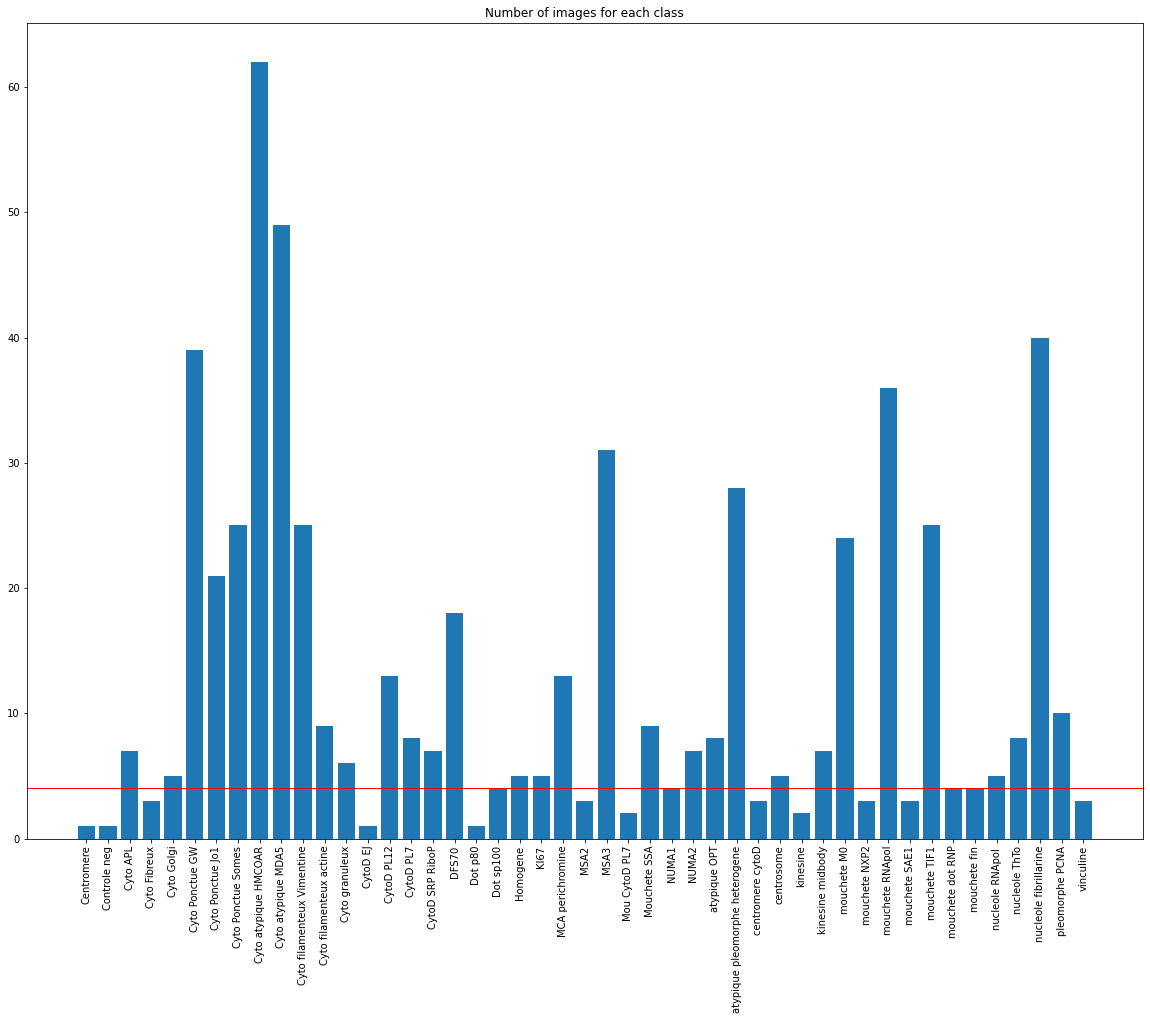

Number of classes with less than 4 images: 12/47


In [8]:
pattern_folder = '/content/drive/MyDrive/Images/Cells/Full_image_cells'

sizes_of_classes = [len(glob.glob(pattern_path + '/*'))//2 for pattern_path in sorted(glob.glob(pattern_folder + '/*'))]

n_classes = len(glob.glob(pattern_folder + '/*'))
y_pattern_dict = n_classes*[None]
for i, pattern_path in enumerate(sorted(glob.glob(pattern_folder + '/*'))): #iterating in every pattern
    pattern_name =  pattern_path[len(pattern_folder)+1:] #Name of pattern
    y_pattern_dict[i] = pattern_name
y_pattern_dict[i] = pattern_name
plt.figure(figsize=(20,15))
plt.title("Number of images for each class")
plt.xticks(rotation='vertical')
plt.axhline(y=4,linewidth=1, color='red')
plt.bar(y_pattern_dict,sizes_of_classes)
plt.show()

print(f"Number of classes with less than 4 images: {(np.asarray(sizes_of_classes, dtype=int)<4).sum()}/{n_classes}")

In [9]:
# number of images
pattern_folder = '/content/drive/MyDrive/Images/Cells/Full_image_cells'
X, y, n_classes, y_pattern_dict, hist_pixel_count, hist_percentage_cyto = get_patterns(pattern_folder, 200, green=True)

Importing...
Importing patterns: Centromere - 0/47
Centromere_1G.npy - 76
Centromere_1G.npy - 76
Centromere_1G.npy - 76
Importing patterns: Controle neg - 1/47
Controle neg_1G.npy - 134
Controle neg_1G.npy - 134
Importing patterns: Cyto APL - 2/47
Cyto APL_1G.npy - 49
Cyto APL_2G.npy - 29
Cyto APL_3G.npy - 39
Cyto APL_4G.npy - 24
Cyto APL_5G.npy - 67
Importing patterns: Cyto Fibreux - 3/47
Cyto Fibreux_1G.npy - 34
Cyto Fibreux_2G.npy - 22
Cyto Fibreux_3G.npy - 50
Cyto Fibreux_1G.npy - 34
Cyto Fibreux_2G.npy - 22
Cyto Fibreux_3G.npy - 50
Importing patterns: Cyto Golgi - 4/47
Cyto Golgi_1G.npy - 33
Cyto Golgi_2G.npy - 45
Cyto Golgi_3G.npy - 47
Cyto Golgi_4G.npy - 61
Cyto Golgi_5G.npy - 44
Importing patterns: Cyto Ponctue GW - 5/47
Cyto Ponctue GW_10G.npy - 76
Cyto Ponctue GW_11G.npy - 37
Cyto Ponctue GW_12G.npy - 57
Cyto Ponctue GW_13G.npy - 38
Importing patterns: Cyto Ponctue Jo1 - 6/47
Cyto Ponctue Jo1_10G.npy - 64
Cyto Ponctue Jo1_11G.npy - 45
Cyto Ponctue Jo1_12G.npy - 58
Cyto Ponctu

Preparing the dataset

In [10]:
primary_df, primary_classes = get_primary_classes()
print(f'Dataframe shape: {primary_df.shape} ')
primary_df

Dataframe shape: (57, 47) 


,centromere,controle neg,cyto apl,cyto fibreux,cyto golgi,cyto ponctue gw,cyto ponctue jo1,cyto ponctue somes,cyto atypique hmcoar,cyto atypique mda5,cyto filamenteux vimentine,cyto filamenteux actine,cyto granuleux,cytod ej,cytod pl12,cytod pl7,cytod srp ribop,dfs70,dot p80,dot sp100,homogene,ki67,mca perichromine,msa2,msa3,mou cytod pl7,mouchete ssa,numa1,numa2,atypique opt,atypique pleomorphe heterogene,centromere cytod,centrosome,kinesine,kinesine midbody,mouchete m0,mouchete nxp2,mouchete rnapol,mouchete sae1,mouchete tif1,mouchete dot rnp,mouchete fin,nucleole rnapol,nucleole thto,nucleole fibrillarine,pleomorphe pcna,vinculine
centromere,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
controle,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
neg,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cyto,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
apl,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
fibreux,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
golgi,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ponctue,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
gw,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
jo1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


For the classification of these imbalanced datasets we used weights to classes to make up for the imbalance, other methods were studied, but this seemed the most fiting for this case.
Source for other methods and explanation as o why we picked this one:
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

We tested some of them and the unweighted produced some good results but for the often missclassified classes it performed worse, so we continue with the unweighted.

For our purposes, a better overall AUC ROC is prefered for the predicted test.

The use of weights permited us to control the False negatives and False positives, but since the objetive is to predict the most probable composite class from a joint prediction of primary classes, favoring True positives or  true negatives is counter productive.


In [11]:
# this an avarage class weights to represent what we do
# but the actual class weights are calculated taking 
# the number of cells into account as well
class_weights = primary_df.sum(axis=1)
class_weights
n_primary_classes = primary_df.shape[0]
primary_classes = primary_df.index.values

In [12]:
x_train, y_train, x_test, y_test = data_preparation(X, y, True, hist_pixel_count, hist_percentage_cyto, image_reshape_size, y_pattern_dict)

Filtering
the total number of images is: 10670
the number of images with these restrictions is: 7248
Normalizing images
Making cells square
Resizing to the correct size for classification
Train test splitting
Data augmentation


Load classification model

In [13]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Total Falses: ', np.sum(cm[1]))

def get_multi_class_model():
  model = VGG16(include_top=False, input_shape=(image_reshape_size, image_reshape_size, 3), weights = 'imagenet')
  for layer in model.layers:
      layer.trainable = False
  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  #class1 = Dense(1024, activation='relu')(flat1)
  class2 = Dense(512, activation='relu')(flat1)
  class3 = Dense(256, activation='relu')(class2)
  drop = Dropout(0.3)(class3)
  output = Dense(1, activation='sigmoid')(drop)
  # define new model
  model = Model(inputs=model.inputs, outputs=output)
  # summarize
  METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
  ]
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001),metrics=METRICS) 
  return model



Train and evaluate

In [14]:
y_train = category_to_multi_label(y_train, y_pattern_dict, primary_df)
y_test = category_to_multi_label(y_test, y_pattern_dict, primary_df)

In [15]:
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow
import gc

# Reset Keras Session
def reset_keras(model):
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass
    try:  
        gc.collect()
        print("Clearing GPU") # if it's done something you should see a number being outputted
    except:
       print("Failed clearing GPU")
    # use the same config as you used to create the session
    config = tensorflow.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.compat.v1.Session(config=config))

In [16]:

from sklearn.utils import class_weight
rocauc_weights = []
for i, pc in enumerate(primary_classes):
  print(f'Primary class: {pc}')
  n_epochs = 10
  batch_size = 64
  steps = 50
  # fit
  # prepare for multilabel classification
  model = get_multi_class_model()
  class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                              classes = np.unique(y_train[i]),
                                              y = y_train[i])
  class_weights = dict(zip(np.unique(y_train[i]), class_weights))
  model.fit(x_train, y_train[i], epochs=n_epochs, batch_size=batch_size, steps_per_epoch=steps,validation_data=(x_test, y_test[i]), class_weight=class_weights)

  # test data properly with auc roc accuracy for unbalanced data
  yhat = model.predict(x_test)
  score = roc_auc_score(y_test[i], yhat)
  print('ROC AUC: %.3f \n' % score)
  
  # check results
  baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
  for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
  print()

  plot_cm(y_train[i], model.predict(x_train))

  
  rocauc_weights.append(score)
  reset_keras(model)


Primary class: centromere
58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/10
50/50 [==============================] - 13s 64ms/step - loss: 0.5688 - auc: 0.8558 - val_loss: 0.2179 - val_auc: 0.9425
Epoch 2/10
50/50 [==============================] - 2s 43ms/step - loss: 0.3684 - auc: 0.9198 - val_loss: 0.3396 - val_auc: 0.9535
Epoch 3/10
50/50 [==============================] - 2s 43ms/step - loss: 0.3233 - auc: 0.9451 - val_loss: 0.4998 - val_auc: 0.9692
Epoch 4/10
50/50 [==============================] - 2s 43ms/step - loss: 0.2779 - auc: 0.9511 - val_loss: 0.1031 - val_auc: 0.9687
Epoch 5/10
50/50 [==============================] - 2s 43ms/step - loss: 0.1861 - auc: 0.9790 - val_loss: 0.0810 - val_auc: 0.9713
Epoch 6/10
50/50 [==============================] - 2s 43ms/step - loss: 0.2082 - auc: 0.9737 - val_loss: 0.4384 - val_auc: 0.9818
Epoch 7/10
50/50 [==============================] - 3s 61ms/step - loss: 0.2431 - auc: 0.9587 - val_loss: 0.5203 - val_auc

In [18]:
rocauc_noweights = []
weight_list = []
for i, pc in enumerate(primary_classes):
  print(f'Primary class: {pc}')
  n_epochs = 10
  batch_size = 64
  steps = 50
  # fit
  # prepare for multilabel classification
  model = get_multi_class_model()
  model.fit(x_train, y_train[i], epochs=n_epochs, batch_size=batch_size, steps_per_epoch=steps,validation_data=(x_test, y_test[i]))

  # test data properly with auc roc accuracy for unbalanced data
  yhat = model.predict(x_test)
  score = roc_auc_score(y_test[i], yhat)
  print('ROC AUC: %.3f \n' % score)
  rocauc_noweights.append(score)
  weights = model.get_weights()
  weight_list.append(weights)

  # check results
  baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
  for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
  print()

  plot_cm(y_train[i], model.predict(x_train))


  # reset GPU
  reset_keras(model)

Primary class: centromere
Epoch 1/10
50/50 [==============================] - 3s 52ms/step - loss: 0.1765 - auc: 0.7435 - val_loss: 0.0940 - val_auc: 0.9342
Epoch 2/10
50/50 [==============================] - 2s 43ms/step - loss: 0.0819 - auc: 0.9366 - val_loss: 0.0918 - val_auc: 0.9475
Epoch 3/10
50/50 [==============================] - 2s 44ms/step - loss: 0.0885 - auc: 0.9376 - val_loss: 0.0548 - val_auc: 0.9762
Epoch 4/10
50/50 [==============================] - 2s 43ms/step - loss: 0.0554 - auc: 0.9671 - val_loss: 0.0559 - val_auc: 0.9821
Epoch 5/10
50/50 [==============================] - 2s 43ms/step - loss: 0.0576 - auc: 0.9643 - val_loss: 0.0456 - val_auc: 0.9834
Epoch 6/10
50/50 [==============================] - 2s 43ms/step - loss: 0.0503 - auc: 0.9805 - val_loss: 0.0466 - val_auc: 0.9712
Epoch 7/10
50/50 [==============================] - 2s 43ms/step - loss: 0.0462 - auc: 0.9674 - val_loss: 0.0468 - val_auc: 0.9729
Epoch 8/10
50/50 [==============================] - 2s 43

Save weight for simpler classificatin later 

In [23]:
weight_dest = '/content/drive/MyDrive/Weights/'
np.save(weight_dest+'multi_label_weights_cnn.npy',np.asarray(weight_list))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Visualization of classification

In [19]:
rouc_by_primary = pd.DataFrame(index=primary_df.index)
rouc_by_primary["Baseline"] = rocauc_noweights
rouc_by_primary["With weights"] = rocauc_weights

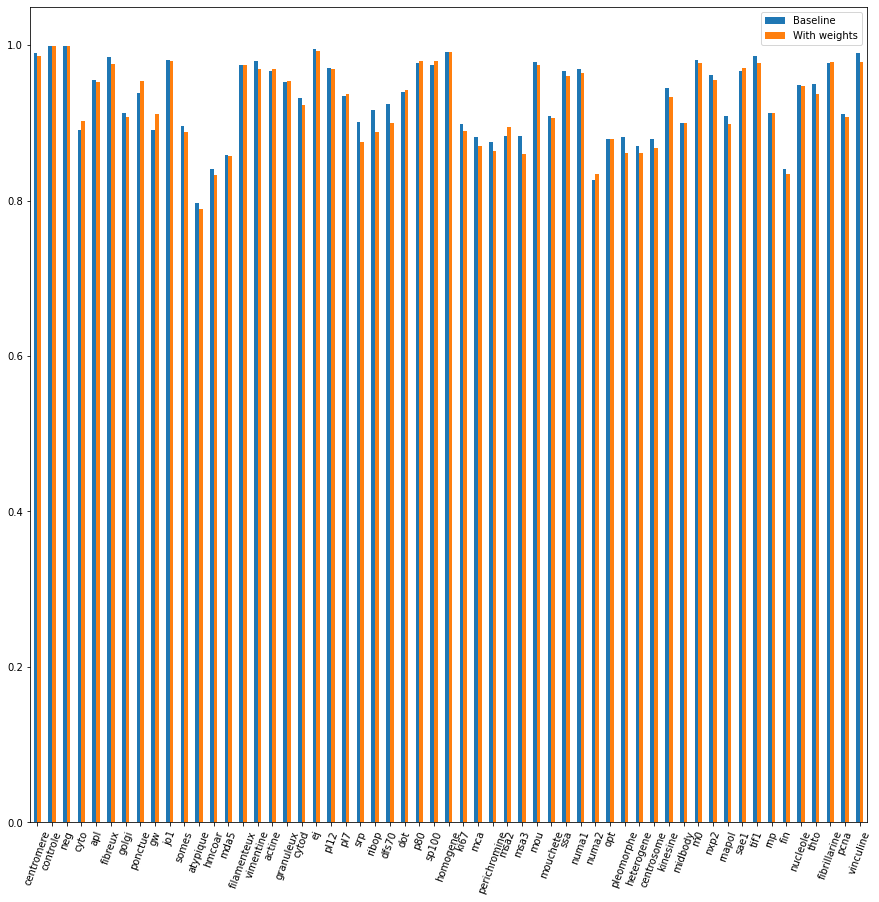

In [20]:
ax = rouc_by_primary.plot.bar(figsize=(15,15), rot=70)

# Classification for patterns before classification in levels
We can limit the number of images to 1 per pattern for the classification, to mirror a doctor, by just leaving one image per folder.

In [21]:
# number of images
pattern_folder = '/content/drive/MyDrive/Images/Cells/CytoCells_pattern'
images_path = "/content/drive/MyDrive/Images/Patterns"
# we limit the number of images to 1
X, y, n_patterns, pattern_dict, hist_pixel_count, hist_percentage_cyto = get_patterns_by_image(pattern_folder, 1, images_path)

Output hidden; open in https://colab.research.google.com to view.

In [35]:
def classify_patterns(X, y, n_patterns, pattern_dict, n_primary_classes, hist_pixel_count, hist_percentage_cyto, weight_list, image_reshape_size, primary_classes):
  pattern_count = 0
  classification_threshold = 0.5
  print("Predicting...")
  for i, j in zip(X, y):
    # i = X[pattern i], j = y[pattern j]
    # make predictions
    print(f"Pattern {pattern_dict[pattern_count]}")
    x_pred, _ = data_preparation(np.asarray(i), np.asarray(j), False, hist_pixel_count, hist_percentage_cyto, image_reshape_size, pattern_dict)
    
    # for every cell of x_pred we have n_primary_classes possible pcs
    predictions = np.zeros((x_pred.shape[0], n_primary_classes))
    # pc = primary class 
    model = get_multi_class_model()
    for pc in range(n_primary_classes):
      model.set_weights(weight_list[pc])
      pc_prediction = model.predict(x_pred) > classification_threshold
      predictions[:, pc] = np.ravel(pc_prediction)
      if sum(pc_prediction)>0:

        print(f'Cells classified as {primary_classes[pc]}')
        plot_predictions(x_pred[np.ravel(pc_prediction)==1], image_reshape_size, pattern_dict, pattern_count)

    
    # for all images get most probable class
    main_predictions = np.sum(predictions, axis=0)/n_primary_classes 
    
    # print best classes
    pattern_classes = get_prediction(main_predictions, primary_classes, n_primary_classes) 

    # plot predictions
    plot_predictions(x_pred, image_reshape_size,  pattern_dict, pattern_count)
    pattern_count += 1

def get_prediction(main_predictions, primary_classes, n_primary_classes, top5=False):
  predicted_classes = np.argsort(-main_predictions)
  print(f"Top Predictions:")
  count = 1
  for i in predicted_classes:
    if main_predictions[i]>0:
      print(f'{count} - {primary_classes[i]}\n')
      count += 1
      if top5==True and count>5:
        break
    else: 
      break


def plot_predictions(x_pred, image_reshape_size, pattern_dict, pattern_count):
  print(f"Number of cells: {x_pred.shape[0]}")
  mozaic , n = cells_plot(x_pred[:,:,:,0], image_reshape_size, 10)
  fig = plt.figure(figsize=(15,15))
  plt.imshow(mozaic)
  plt.title(f'Pattern {pattern_dict[pattern_count]}')
  plt.show()

In [24]:

weight_dest = '/content/drive/MyDrive/Weights/'
weight_list = np.load(weight_dest+'multi_label_weights_cnn.npy', allow_pickle= True)

In [36]:
classify_patterns(X, y, n_patterns, pattern_dict, n_primary_classes, hist_pixel_count, hist_percentage_cyto, weight_list, image_reshape_size, primary_classes)

Output hidden; open in https://colab.research.google.com to view.